In [2]:
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import gym
import math
from matplotlib import rc
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
from gym.envs.registration import register
import time
from IPython.display import clear_output
from scipy.signal import savgol_filter

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [8]:
MAP = [
    "+---------+",
    "|R: :A: :G|",
    "| : : : : |",
    "| :A:A: : |",
    "| : : : : |",
    "|Y: :A:B: |",
    "+---------+",
]


class SafeCab(discrete.DiscreteEnv):
    """
    Modified Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world indicated by R(ed), B(lue), G(reen), and Y(ellow). 
    When the episode starts, the taxi starts off at a random square and the passenger is at a random location. 
    The taxi drive to the passenger's location, pick up the passenger, 
    drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger. 
    The episode ends if the taxi ends up on anomaly location. Once the passenger is dropped off, the episode ends.

    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 
    5 possible locations of the passenger (including the case when the passenger is the taxi), 
    and 4 destination locations. 
    
    Actions: 
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +1000 for delievering the passenger. 
    There is a reward of -10 for executing actions "pickup" and "dropoff" illegally. 
    Interaction with an anomaly gives -1000 reward and end the episode.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - red: anomaly
    - other letters (R, G, B and Y): locations for passengers and destinations

    actions:
    - 0: south
    - 1: north
    - 2: east
    - 3: west
    - 4: pickup
    - 5: dropoff

    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]
        self.anomaly_locs = [(0,2), (2,1), (2,2), (4,2)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1 # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2:
                                new_col = min(col + 1, max_col)
                            elif action == 3:
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else: # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 1000
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # dropoff at wrong location
                                    reward = -10
                                    
                            new_loc = (new_row, new_col)
                            if new_loc in self.anomaly_locs:
                                reward = -1000
                                done = True
                                
                            new_state = self.encode(new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append((1.0, new_state, reward, done))
                            
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)
        
        def ul(x): return "_" if x == " " else x
        
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        
        for (zx, zy) in self.anomaly_locs:
          out[1 + zx][2 * zy + 1] = utils.colorize(
            out[1 + zx][2 * zy + 1], 'red', bold=True)
        
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
              
register(
    id='SafeCab-v0',
    entry_point=f"{__name__}:SafeCab",
)

In [9]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Episode: {frame['episode']}")
        print(f"Timestep: {frame['step']}")
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(4)

In [10]:
env = gym.make('SafeCab-v0')

In [14]:
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: :A: :G|
| : : : : |
| :A:A: : |
| : : : : |
|Y: :A:B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [19]:
class Agent:
    def __init__(self, n_states, n_actions, decay_rate=0.0001, learning_rate=0.7, gamma=0.618):
        self.n_actions = n_actions
        self.q_table = np.zeros((n_states, n_actions))
        self.epsilon = 1.0
        self.max_epsilon = 1.0
        self.min_epsilon = 0.01
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.gamma = gamma #discount rate
        self.epsilons_ = []
        
    def choose_action(self, explore=True):
        exploration_tradeoff = np.random.uniform(0,1)

        if explore and exploration_tradeoff < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[state, :])
            
    def learn(self, state, action, reward, next_state, done, episode):
        self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.q_table[new_state, :]) - self.q_table[state, action])

        if done:
            #reduce epsilon to decrease the explore over time
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
            self.epsilons_.append(self.epsilon)
                
        
        

In [20]:
total_episodes = 60000
total_test_episodes = 10

agent = Agent(env.observation_space.n, env.action_space.n)

In [21]:
untrainded_frames = []

for episode in range(total_test_episodes):
    state = env.reset()
    step = 1
    while True:
        action = agent.choose_action()
        new_state, reward, done, info = env.step(action)
        untrainded_frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'episode': episode + 1,
            'step': step,
            'reward' : reward
        })
        
        if done:
            step = 0
            break
        state = new_state
        step += 1

In [22]:
print_frames(untrainded_frames)

+---------+
|R: :A: :G|
| : : : : |
| :A:A: : |
| : : : : |
|Y: :A:B: |
+---------+
  (North)

Episode: 10
Timestep: 2
State: 152
Reward: -1000


In [23]:
rewards = []

for episode in range(total_episodes):
    state = env.reset()
    episode_rewards = []
    
    while True:
        action = agent.choose_action()
        new_state, reward, done, info = env.step(action)
        agent.learn(state, action, reward, new_state, done, episode)
        state = new_state
        episode_rewards.append(reward)
        if done==True:
            break
    rewards.append(np.mean(episode_rewards))

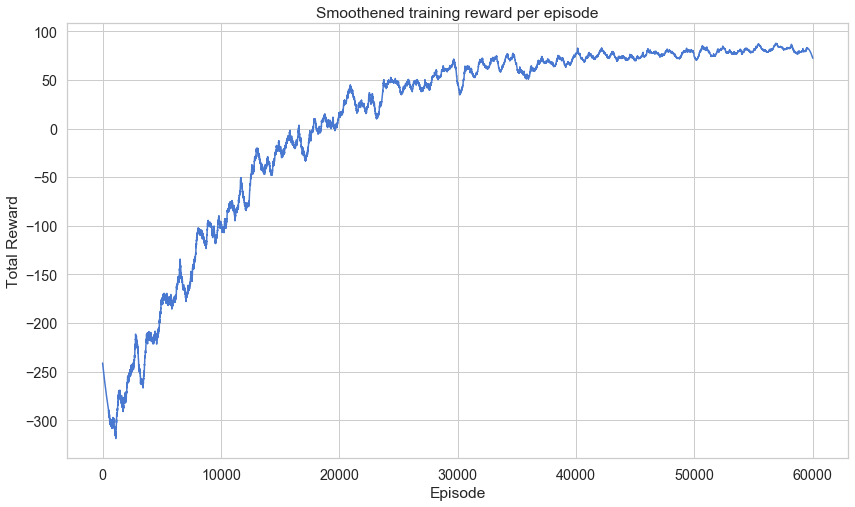

In [24]:
plt.plot(savgol_filter(rewards, 1001, 2))
plt.title("Smoothened training reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

Text(0, 0.5, 'Epsilon')

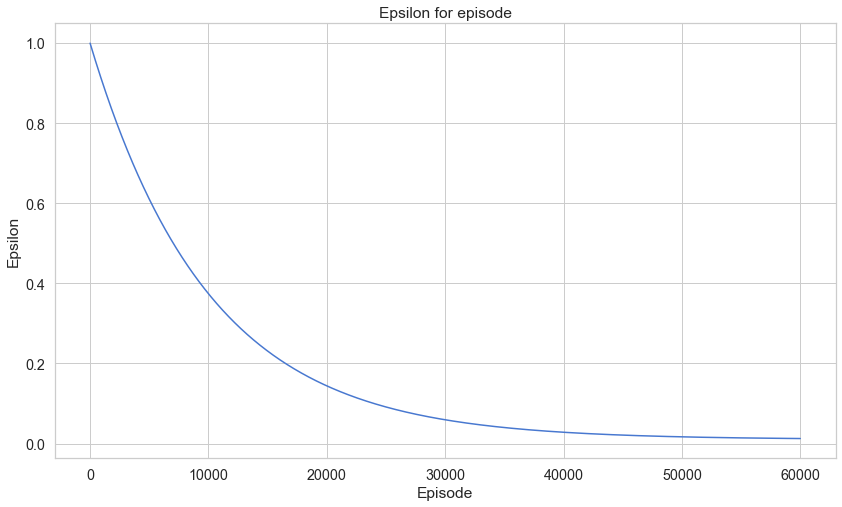

In [25]:
plt.plot(agent.epsilons_)
plt.title("Epsilon for episode")
plt.xlabel("Episode")
plt.ylabel("Epsilon")